<center><img src="https://www.freewebheaders.com/wp-content/gallery/drinks/awesome-wine-barrel-and-bottle-with-red-wine-glasses-web-header.jpg" width=800 /></center>

# Wine Quality Forecast: Unveiling the Flavorful Future with Data Science

# Project Goal

> Find drivers of wine quality and create a model that can accurately predict wine quality while performing better than baseline.

# Project Description

> Using the dataset for wine quality from [Data World](https://data.world/food/wine-quality), we looked for physicochemical properties that might have an effect on wine quality.

# Initial Hypothesis

> We believe that density, volatile_acidity, alcohol, and chlorides will be the best predictors of wine quality.

# Imports

In [1]:
#Standard imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

import wrangle as w

import warnings
warnings.filterwarnings("ignore")

# Acquire

* Data acquired from Data World
* Combined both csv's and added additional column to include wine_type
* Cached combined file to local csv
* Each row represents a unique wine sample, its physicochemical properties, and its quality

In [2]:
wines = pd.read_csv('wines.csv')


In [3]:
wines.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,wine_type
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6,white
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6,white
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6,white
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6,white


# Prepare

* Visualized full dataset for univariate exploration
    * Histograms showed normal distributions
    * Handled outliers by removing top 1% of values in each column
* Created new column (quality_bin) for target variable:
    * **Bad = 3-5**
    * **Good = 6-9**
* Verified datatypes
* Corrected column names
* Checked for nulls (there were none)
* Split the data, stratifying on quality_bin

In [4]:
wines = w.prepare_data(wines)

train, validate, test = w.split_data(wines, 'quality_bin') #Split data on quality_bin

train.head() #Pulse check

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality,wine_type,quality_bin
2614,6.15,0.21,0.37,3.2,0.021,20.0,80.0,0.99076,3.39,0.47,12.0,5,white,bad
671,6.60,0.28,0.36,1.7,0.038,22.0,101.0,0.99120,3.29,0.57,11.6,6,white,good
4746,6.30,0.23,0.50,10.4,0.043,61.0,132.0,0.99542,2.86,0.46,9.1,6,white,good
2647,5.80,0.15,0.28,0.8,0.037,43.0,127.0,0.99198,3.24,0.51,9.3,5,white,bad
4867,5.30,0.60,0.34,1.4,0.031,3.0,60.0,0.98854,3.27,0.38,13.0,6,white,good


## Explore

### Which numeric variables are most correlated with quality?

### Bivariate Exploration

Here, we isolated the features from the pairplot with the highest correlations to wine quality.

$H_0$: There is no correlation between our selected features (density, pH, alcohol, sulphates) and our target variable (quality).

$H_\alpha$: There is a correlation between our selected features and our target variable (quality).

$\alpha$: 0.05

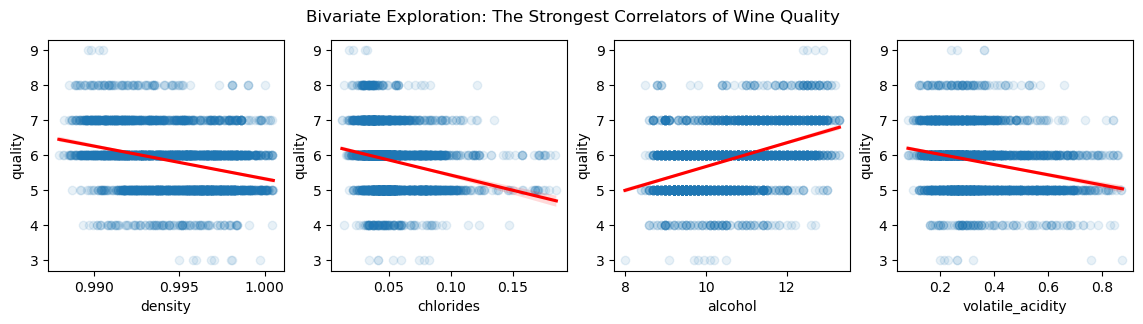

In [5]:
#Visualization to show only the graphs with the highest correlations.

w.correlation_charts(train)

Running Pearson's Test to verify correlation and p-values.

In [6]:
#To sort values by correlation, we had to take the absolute values, reflected under R.

corr_df = w.correlation_tests(train[['density', 'chlorides', 'alcohol', 'volatile_acidity', 'wine_type', 'quality']])
corr_df

,feature,r,p
4,quality,1.000000,0.000000e+00
2,alcohol,0.453331,4.252438e-178
0,density,0.307832,3.490146e-78
3,volatile_acidity,0.253654,7.762193e-53
1,chlorides,0.238127,1.349135e-46


This confirms that the correlation coefficients of all the selected features were not just due to chance.

Among all twelve features, alcohol, density, volatile_acidity, and chlorides had the highest correlation with wine quality. We will keep that in mind as we move into exploring clusters (multivariate exploration).

### Which clusters are most helpful in predicing wine quality?

### Multivariate Exploration

We created visualizations using all combinations of the above mentioned variables against the binned target variable.

In [7]:
#Scaling selected features to work with clustering models. Checking index in dataframe to verify randomization.

train_scaled, validate_scaled, test_scaled =  w.scale_data(train, validate, test, cols=train.iloc[:, 0:11].columns)
train_scaled[['density', 'chlorides', 'volatile_acidity', 'alcohol', 'quality_bin']].head()

,density,chlorides,volatile_acidity,alcohol,quality_bin
2614,0.224522,0.052023,0.163522,0.754717,bad
671,0.259554,0.150289,0.251572,0.679245,good
4746,0.595541,0.179191,0.188679,0.207547,good
2647,0.321656,0.144509,0.088050,0.245283,bad
4867,0.047771,0.109827,0.654088,0.943396,good


Of all visualizations, the below three stood out to us the most.

In [8]:
#Running through K Means modeling to create the clusters in our data.
c_list = ['red', 'green']
init_list = [np.array([[0.0,0.6], [0.5,0.6]], np.float64), np.array([[0.1,0.2], [0.3,0.175]], np.float64), np.array([[0.2,0.3], [0.2,0.2]], np.float64)]
train_scaled, validate_scaled, test_scaled = w.get_cluster_columns(train_scaled, validate_scaled, test_scaled, features_list= [['volatile_acidity', 'density'],['volatile_acidity', 'alcohol'],['chlorides', 'alcohol']], clusters =2, init_array=init_list, iterations = 1)

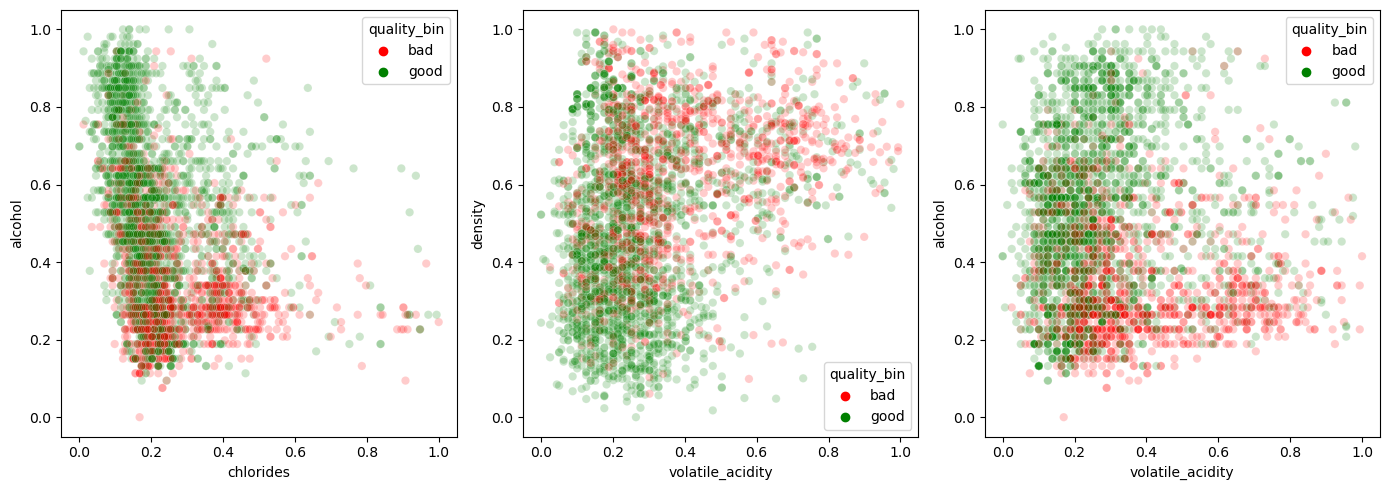

In [9]:
#Displays top three graphs with most prominent cluster.
w.subplots_one(train_scaled)

Now we'll look at each graph individually and superimpose our own clustering model on top.

<h2><i>Volatile Acidity vs. Density</i></h2>

<h3><center>Bad wines have higher volatile acidity and more density</center></h3>

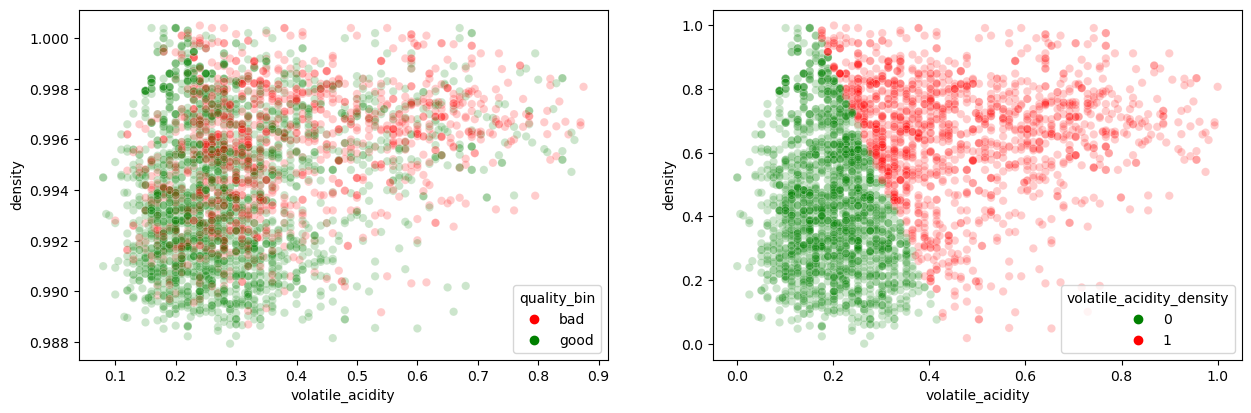

In [10]:
w.train_scaled_two(train, train_scaled, c_list)

<h2><i>Volatile Acidity vs. Alcohol</i></h2>

<h3><center>Bad wines have less alcohol content and greater volatile acidity</center></h3>

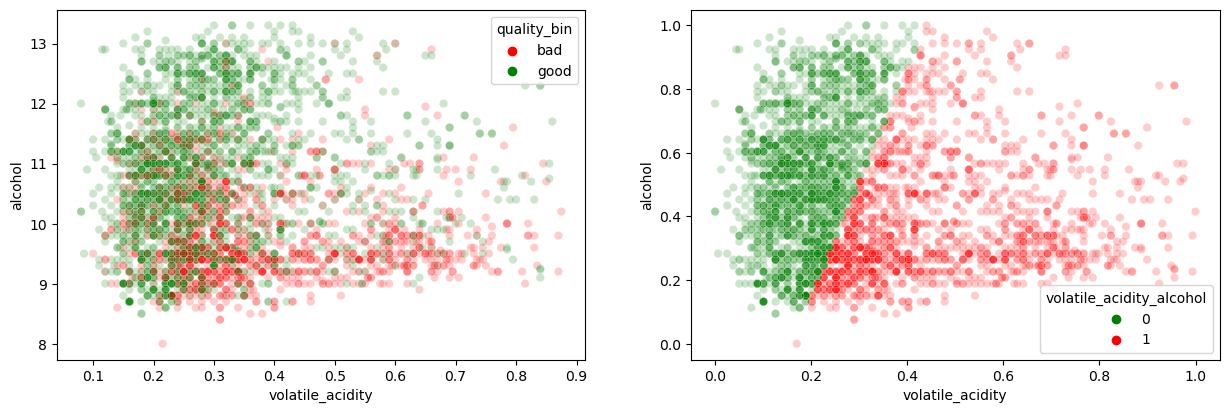

In [11]:
w.train_scaled_three(train, train_scaled, c_list)

<h2><i>Chlorides vs. Alcohol</i></h2>

<h3><center>Bad wines have less alcohol content and higher amount of chlorides</center></h3>

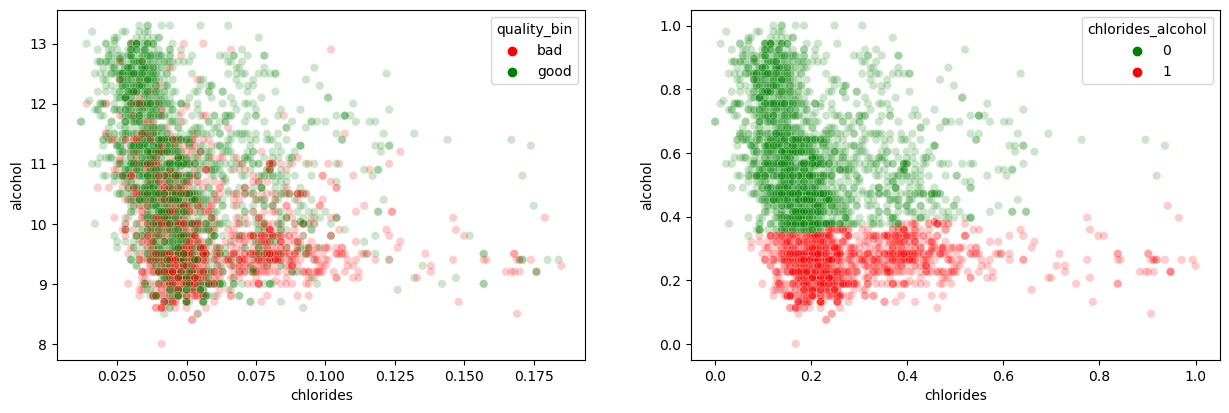

In [12]:
w.train_scaled_four(train, train_scaled, c_list)

### Now that we've created the clustering models, we'll run those clusters through a stats test (chi$^2$).

$H_0$: There is no difference in the means of the clustered sets amongst each other for quality.

$H_\alpha$: There is a difference in the means of the clusters sets amongst each other for quality.

In [13]:
chi_df = w.chi2_test(train_scaled, [['volatile_acidity_density', 'quality_bin'],['volatile_acidity_alcohol', 'quality_bin'],['chlorides_alcohol', 'quality_bin']])
chi_df[['feature','chi2','p']]

,feature,chi2,p
1,"[volatile_acidity_density, quality_bin]",298.727676,6.236915e-67
2,"[volatile_acidity_alcohol, quality_bin]",442.347606,3.338257e-98
3,"[chlorides_alcohol, quality_bin]",452.209171,2.384194e-100


The cluster with the lowest p-value was the volatile acidity and the alcohol combination. We will proceed with this cluster.

### Exploration Summary

* Predicting quality is predicted to be easier when separated into two bins of "good" vs. "bad" wines.
* Of all physicochemical properties, alcohol, density, volatile_acidity, and chlorides were the properties with the highest correlation with quality.
* Of the 55 graphs that we looked through, the features volatile_acidity, alcohol, density, and chlorides had the most prominent clusters.
* Of the 3 graphs that we proceeded with, the combination of alcohol and chlorides had the best accuracy of good vs. bad wines.
* We will proceed with feeding the cluster of alcohol + chlorides into the model, as well as the independent variables of density and volatile acidity.

## Modeling

### Scaling on selected features to be sent into model

In [14]:
X_train, X_validate, X_test, y_train, y_validate, y_test = w.mvp_info(train_scaled, validate_scaled, test_scaled,list_of_features=['chlorides_alcohol', 'volatile_acidity', 'density'])

X_train.head()

,chlorides_alcohol,volatile_acidity,density
2614,0,0.163522,0.224522
671,0,0.251572,0.259554
4746,1,0.188679,0.595541
2647,1,0.088050,0.321656
4867,0,0.654088,0.047771


### Establish baseline

In [15]:
#Count of mode ('good') over total amount of wines.

2255/(2255+1267)

0.6402612152186258

Baseline: 0.640

Running stats tests on four different classification models.

In [16]:
df, test_df = w.create_random_forest(X_train,y_train, X_validate, y_validate, X_test, y_test)

In [17]:
w.super_classification_model(X_train,y_train, X_validate, y_validate, the_c = 1)

,model_train,train_predict,validate_predict
0,baseline,0.639977,0.639977
1,KNeighborsClassifier,0.755000,0.728000
2,LogisticRegression,0.733000,0.733000
3,RandomForestClassifier,0.752000,0.739000
4,DecisionTreeClassifier,0.767000,0.735000


Random Forest Classifier with max_depth=4 produced the best results. We will use this on our test data.

In [18]:
test_df

,model_train,baseline,max_depth
0,RandomForestClassifier,0.639977,max_depth
1,RandomForestClassifier,0.734000,4


### Modeling Summary

* Established baseline to beat at: 64%
* Ran through four different classification models.
* Random Forest at max_depth=4 performed the best with an accuracy score of 74%.
* Ran final model on test data set. Result: 73%.

# Conclusion

* Our top model beat the baseline by around 10%.
* Our clustering and independent variables were able to predict wine quality with greater accuracy.

## Recommendations

* Use our model to predict whether a wine is good or bad with greater accuracy.

## Next Steps

* Send in all features independently of each other.
* Compare that to clustered features' effect on models.
* Do a deeper dive into white vs. reds to see if alternate clusters exist and create individual models.